# Stock Price Prediction Using LSTM

This Jupyter notebook demonstrates how to predict stock prices using Long Short-Term Memory (LSTM) networks. Below is a detailed explanation of the code with underlying concepts.

---
## Key Concepts and Techniques Used:

1. **LSTM (Long Short-Term Memory)**: A type of Recurrent Neural Network (RNN) that is especially useful for sequential data because it can capture long-term dependencies in time series data.  
2. **Time Series Data**: Data points ordered by time, where each data point is dependent on previous ones.  
3. **Normalization**: Scaling the data to a range (0-1) to improve the training process, especially for neural networks.  
4. **Dropout**: A regularization technique used in neural networks to reduce overfitting.  
5. **Stock Price Prediction**: The goal is to forecast future stock prices based on historical data.  
---

## 1. Importing Necessary Libraries

- **numpy**: A library for numerical operations, commonly used for handling arrays and performing mathematical computations.<br>

- **pandas**: A library for data manipulation and analysis, particularly useful for working with time series data.<br>

- **matplotlib.pyplot**: A plotting library used to visualize data (in this case, stock prices and moving averages).<br>

- **yfinance**: A Python library to fetch historical stock price data from Yahoo Finance.<br>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

## 2. Downloading Stock Data

- **start and end**: Defines the time range for downloading stock data (from January 1, 2012, to December 21, 2022).  

- **stock = 'GOOG'**: Symbol for Google stock.  

- **yf.download()**: Downloads historical stock data for the specified stock (GOOG) from Yahoo Finance, over the defined period.  

- **reset_index(inplace=True)**: Resets the index of the DataFrame to a default integer index, making the date column a regular column instead of an index.

start = '2012-01-01'
end = '2022-12-21'
stock = 'GOOG'

data = yf.download(stock, start, end)

In [4]:
data.reset_index(inplace=True)

In [5]:
data

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2012-01-03,16.262545,16.641375,16.248346,16.573130,16.513794,147611217
1,1,2012-01-04,16.563665,16.693678,16.453827,16.644611,16.585020,114989399
2,2,2012-01-05,16.491436,16.537264,16.344486,16.413727,16.354961,131808205
3,3,2012-01-06,16.417213,16.438385,16.184088,16.189817,16.131853,108119746
4,4,2012-01-09,16.102144,16.114599,15.472754,15.503389,15.447884,233776981
...,...,...,...,...,...,...,...,...
2756,2756,2022-12-14,95.540001,97.220001,93.940002,95.309998,94.968765,26452900
2757,2757,2022-12-15,93.540001,94.029999,90.430000,91.199997,90.873482,28298800
2758,2758,2022-12-16,91.199997,91.750000,90.010002,90.860001,90.534698,48485500
2759,2759,2022-12-19,90.879997,91.199997,88.925003,89.150002,88.830818,23020500


## 3. Calculating Moving Averages
- **Moving Average**: A technique used in time series analysis to smooth out short-term fluctuations and highlight longer-term trends.  
- **rolling(100).mean()**: Computes the 100-day moving average of the stock’s closing prices.  
- **plt.plot()**: Plots the data on a graph, where the red line represents the 100-day moving average, and the green line is the actual closing prices.  


In [6]:
ma_100_days = data.Close.rolling(100).mean()

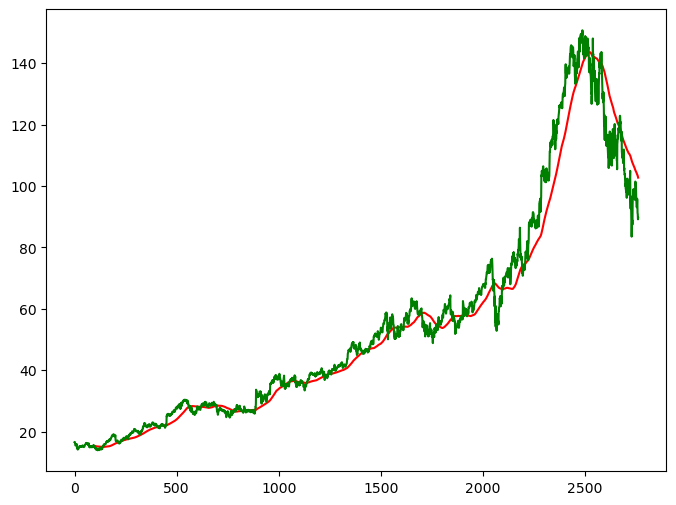

In [7]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data.Close, 'g')
plt.show()

## 4. Comparing 100-Day and 200-Day Moving Averages
- **200-Day Moving Average**: Another moving average that captures longer-term trends.  
- **Comparison**: The red line represents the 100-day moving average, the blue line represents the 200-day moving average, and the green line shows the actual closing prices. This allows comparison of short-term vs. long-term trends.  


In [8]:
ma_200_days = data.Close.rolling(200).mean()

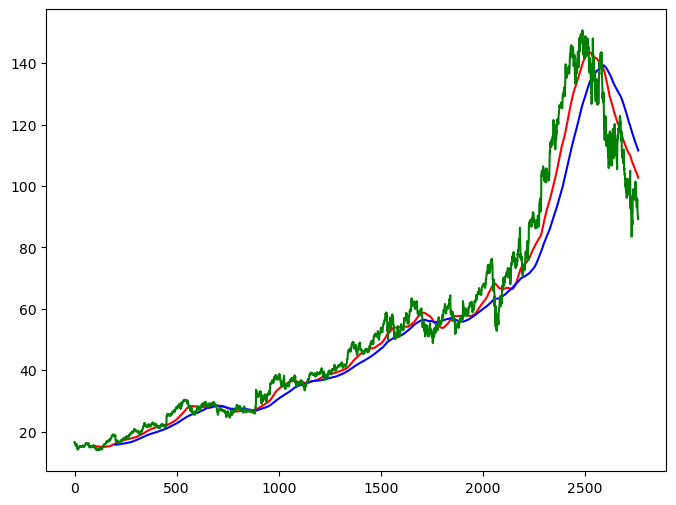

In [9]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days,'b')
plt.plot(data.Close,'g')
plt.show()

## 5. Data Preprocessing: Handling Missing Values and Splitting the Data
- **dropna(inplace=True)**: Removes any rows with missing values.  
- **Splitting Data**: The data is split into training (80%) and testing (20%) sets for model training and evaluation.  


In [10]:
data.dropna(inplace=True)

In [11]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [12]:
data_train.shape[0]

2208

In [13]:
data_test.shape[0]

553

## 6. Feature Scaling (Normalization)
- **MinMaxScaler**: This normalization technique scales the data to a range of 0 to 1, which is important for neural networks, as they perform better when the input data is scaled.  
- **fit_transform()**: Fits the scaler to the training data and transforms the data to the desired scale.  


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [15]:
data_train_scale = scaler.fit_transform(data_train)

## 7. Creating Sequences for LSTM Model
- **LSTM Input Sequences**: LSTMs require sequential input. Here, we create sequences of the previous 100 days’ data (past 100 days) to predict the next day’s price.  
- **x**: The features (input data) for the LSTM model, which consists of 100 previous days of data for each prediction.  
- **y**: The target value (output), which is the closing price for the next day.  


In [16]:
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])
    

In [17]:
x, y = np.array(x), np.array(y)

## 8. Building the LSTM Model
- **LSTM Architecture**:  
    - The model uses four LSTM layers with different units to capture complex patterns and dependencies.  
    - **Dropout layers**: Help prevent overfitting by randomly setting a fraction of input units to 0 during training.  
    - **LSTM layers**: These are the core layers that learn from the sequences of data.  
    - **Dense layer**: The output layer that predicts the next day’s stock price.  
    - **Activation Function**: ReLU (Rectified Linear Unit) is used as the activation function in the LSTM layers, which helps with faster learning.  
    - **adam optimizer**: Adaptive moment estimation (Adam) is a popular optimization algorithm.  
    - **Mean Squared Error (MSE)**: This is the loss function used for regression tasks.  

---

# Core Concepts: Long Short-Term Memory Networks (LSTMs)

## Overview
- **LSTMs** are a type of Recurrent Neural Network (**RNN**) specifically designed to process sequential data, such as **time series**.
- They are capable of learning **long-term dependencies**, making them ideal for tasks like **stock price prediction**, where the value of a stock depends on its historical prices.

---

## Key Concepts

### 1. Sequential Modeling
- The model uses **past 100 days of data** to predict the stock price for the **next time step**.
- By capturing patterns in the sequential data, LSTMs can:
  - Identify **trends** and **seasonal behaviors**.
  - Improve accuracy by leveraging **context from previous time steps**.

### 2. Why LSTMs for Stock Prediction?
- Stock prices exhibit **temporal dependencies**, meaning the current price is influenced by historical data.
- LSTMs use a combination of **forget gates**, **input gates**, and **output gates** to manage the flow of information, enabling them to retain relevant historical context while discarding irrelevant details.

---


In [18]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [19]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1))

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Model Compilation and Training
### Optimizer:
- **The Adam optimizer:**  is an adaptive learning rate optimization algorithm, commonly used in training deep learning models. It combines the advantages of both Adagrad and RMSProp optimizers, making it well-suited for problems involving sparse gradients and noisy data.
### Loss Function:
- **Mean Squared Error (MSE):** is commonly used for regression tasks. It calculates the average of the squares of the differences between actual and predicted values. This helps the model minimize errors during training.


In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

- **x:** The input data, which could be the historical stock prices or any other sequential data.
- **y:** The target data, which is the stock price at the next time step (or the value you’re predicting).
- **Epochs**:  Number of times the model sees the entire training dataset during training.
- The model will train for **50 epochs**, meaning it will go through the entire dataset 50 times.
- **Batch Size**: Number of samples processed before the model updates its weights.
- The batch size of **32 means** the model will update its weights after every 32 samples.
- **Verbose**: Controls the display of progress during training.
- Setting verbose = **1** will show a progress bar during training, providing feedback on the training process


model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

## Application
- The model is now ready to learn from the sequential data (e.g., stock prices) and adjust its internal weights to minimize the prediction error based on the mean squared error loss function.

## 9. Model Summary
- **Model Summary**: Provides an overview of the model architecture, including the number of layers, units in each layer, and the total number of parameters to be learned.  


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,285 (2.05 MB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 357,524 (1.36 MB)

## Model Summary Analysis

The model consists of multiple **LSTM layers** and **Dropout layers** with the following key points:

### 1. **LSTM Layers**
- **LSTM layers** are designed to capture **sequential dependencies** in the input data. This is particularly useful for time-series data like stock prices.
- The model uses 4 LSTM layers with an increasing number of units:
  - First LSTM: 50 units
  - Second LSTM: 60 units
  - Third LSTM: 80 units
  - Final LSTM: 120 units
- These layers return sequences, i.e., the output at each time step is passed to the next layer.

### 2. **Dropout Layers**
- **Dropout layers** are used after each LSTM layer to reduce overfitting. By randomly setting a fraction of the input units to zero during training, the model is encouraged to generalize better.

### 3. **Dense Layer**
- The model ends with a **Dense layer** that outputs a single prediction value (`(None, 1)`), typically used for regression tasks like predicting stock prices.

### 4. **Parameter Overview**
- **Total Parameters**: 536,285
- **Trainable Parameters**: 178,761
- **Non-Trainable Parameters**: 0
- **Optimizer Parameters**: 357,524

The majority of parameters are trainable, and the optimizer itself has a significant number of parameters, which are not updated during training.

---

This model architecture is well-suited for learning long-term dependencies in time-series data, such as stock price prediction, and includes techniques like dropout to avoid overfitting


### Key Observations and Explanation:
- **Increasing LSTM Units:** The number of units increases with each LSTM layer, allowing the model to capture increasingly complex features from the data.
- **Dropout:** Dropout layers are used to prevent the model from overfitting, which is important when working with small datasets or complex models.
- **Output Layer:** The Dense layer with one output unit is appropriate for regression tasks, like predicting the next value in a time series.
- **Parameters:** The model has a significant number of parameters, indicating a relatively complex architecture designed to capture complex patterns in the data.

## 10. Preparing Test Data
- **Preparing Test Data**: To test the model, we concatenate the last 100 days of the training data (the most recent data) with the testing data to create a continuous sequence for prediction.  


### Steps:
1. Extract the last 100 days from the training data.
2. Concatenate these last 100 days with the test data.


In [23]:
pas_100_days = data_train.tail(100)

## 11. Creating Sequences for Test Data
- **Creating Sequences for Test Data**: Similar to the training data, we create sequences of 100 days of historical data for each prediction.  
-  By preparing the data in sequences, we can predict future time steps (such as the next day’s price) based on historical context.
## Explanation of Code

1. **Scaling the Test Data**:
   - `data_test_scale = scaler.fit_transform(data_test)`:
     - The test data is scaled using the same scaling method that was used for the training data (like MinMaxScaler or StandardScaler).
     - Scaling ensures that the test data is transformed into the same range as the training data, making it compatible for predictions by the model.
     - If the scaler was already fitted on the training data, you should use `transform` instead of `fit_transform` to avoid recalculating the scaling parameters.

2. **Creating Sequences**:
   - `x.append(data_test_scale[i-100:i])`:
     - This line takes a sequence of 100 days from the scaled test data. It uses the past 100 days to predict the next day's value.
   - `y.append(data_test_scale[i, 0])`:
     - This line takes the value for the next day (the target value) and adds it to `y`. This is the value the model will try to predict.

3. **Converting Lists to Numpy Arrays**:
   - `x, y = np.array(x), np.array(y)`:
     - After creating the sequences, the lists `x` and `y` are converted into numpy arrays. This is the format that the model expects for training or prediction.

## Why This Step is Important

- **Scaling**: Scaling is essential because neural networks like LSTMs work better when the input data is on a similar scale. By scaling the test data with the same parameters used for the training data, we ensure the model can make meaningful predictions.
  
- **Sequence Creation**: LSTMs need past data to predict future values. By creating sequences of 100 days, we provide the model with enough historical context to make predictions for the next time step (e.g., the next day's value).

- **Reshaping for LSTM**: LSTM models require input data in a specific format, where the data is structured into sequences. The data needs to be in the shape `(samples, time_steps, features)`, where:
  - `samples`: The number of sequences.
  - `time_steps`: The number of days in each sequence (100 days in this case).
  - `features`: The number of features in the data (1 feature for a univariate time series).

In [24]:
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)

In [25]:
data_test_scale  =  scaler.fit_transform(data_test)

In [26]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)

## 12. Making Predictions and Rescaling
- **Prediction**: The model predicts the stock prices for the test data.  
- **Rescaling**: The predicted values and actual values are rescaled back to the original range using the inverse of the MinMaxScaler.  
## Explanation of Code

1. **Making Predictions**:
   - `y_predict = model.predict(x)`:
     - The model is used to predict the stock prices (or other values) based on the input data `x` (which consists of the sequences created from the test data).
     - The model generates predictions for the next day's value, based on the historical 100 days provided in each sequence.

2. **Scaling the Predictions**:
   - `scale = 1 / scaler.scale_`:
     - The inverse of the scaler's scaling factor (`scaler.scale_`) is calculated. This is necessary to transform the predictions back into the original scale of the data.
     - `scaler.scale_` holds the scaling factors for each feature used in the scaling process, so the inverse scales the predictions back to the original range.
   
   - `y_predict = y_predict * scale`:
     - The predictions (`y_predict`) are multiplied by the inverse scale to bring them back to their original values before scaling. This makes the predicted values comparable to the actual (unscaled) values.

3. **Scaling the Actual Data**:
   - `y = y * scale`:
     - The actual target values (`y`) are also scaled back to their original range by multiplying them by the inverse scale factor.
     - This ensures that the predictions and actual values are in the same range for accurate comparison.

## Why This Step is Essential

- **Scaling Predictions**: The model's output is based on the scaled data, so to interpret the predictions correctly, we need to convert them back to the original scale. This is done using the inverse of the scaling factor.
  
- **Consistency**: Scaling the actual values (`y`) ensures that both the predicted values and the actual values are in the same scale, allowing for a proper comparison and evaluation of the model's performance.

In [27]:
y_predict = model.predict(x)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [28]:
scale =1/scaler.scale_

In [29]:
y_predict = y_predict*scale

In [30]:
y = y*scale

## 13. Plotting the Results
- **Visualization**: This step visualizes the predicted and actual stock prices, allowing you to compare the performance of the model.  


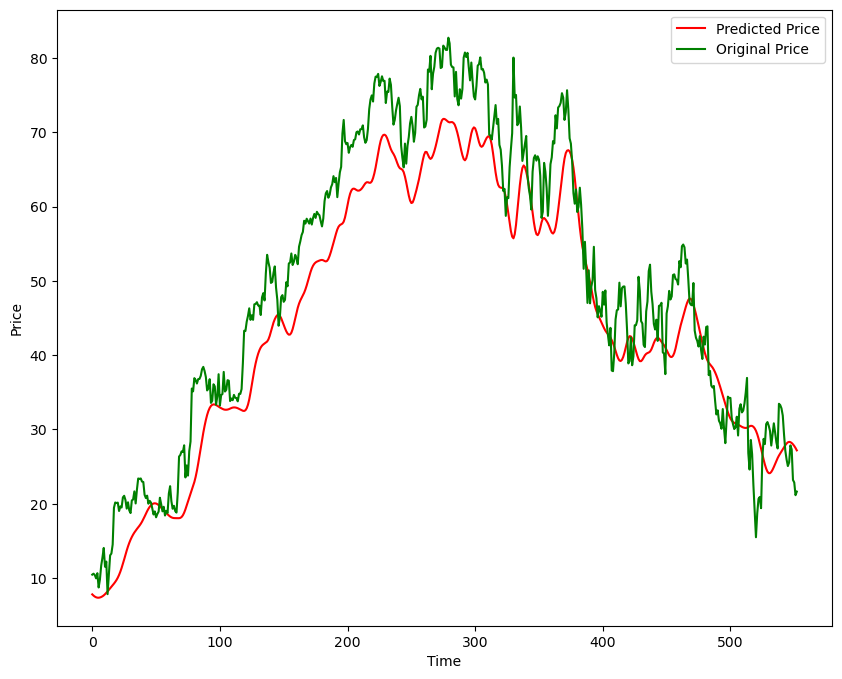

In [31]:
plt.figure(figsize=(10,8))
plt.plot(y_predict, 'r', label = 'Predicted Price')
plt.plot(y, 'g', label = 'Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 14. Saving the Model
- **Model Saving**: The trained model is saved to a file for later use, allowing you to load it and make predictions without retraining.  


In [33]:
model.save('Stock Predictions Model.keras')